# Preliminaries


[Catalog of sources](https://cdsarc.unistra.fr/viz-bin/cat/J/A%2bA/628/A66)

Not sure how to render this:
```
@MISC{ vizier:J/A+A/628/A66, 
author = {Lodieu N., Perez-Garrido A., Smart R.L., Silvotti, R.}, 
title = "{VizieR Online Data Catalog: alpha Persei, Pleiades and Praesepe clusters}", 
year = "2019", 
doi = {10.26093/cds/vizier.36280066}, 
journal = {\aap}
}
```

In [1]:
import astropy.coordinates as coord
from astropy.table import QTable, vstack

import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import pandas as pd
import pickle
import os

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

In [3]:
from cluster import cluster as cl

# Get Lodieu Data Files

Details of processing these data files are [here](https://drive.google.com/file/d/1-BXGwshTcOD1bptRXy_pKGCemQnDY22z/view?usp=sharing)


In [4]:
alpha_per = cl('alpha_per','./data/J_A+A_628_A66')

In [5]:
alpha_per.objs.head()

,RAdeg,DEdeg,SourceCP,RVCP,e_RVCP,PlxCP,e_PlxCP,GmagCP,pmRACP,e_pmRACP,...,Mode,RV,e_RV,o_RV,rest,b_rest,B_rest,rlen,ResFlag,ModFlag
0,34.813290,52.493074,455075360092433920,-9999.0,-9999.0,5.77091,0.109942,16.5334,27.646,0.350,...,0,0.0,0.0,0,171.669,168.464,174.996,827.580,1,1
1,35.010252,52.664085,455037048980464896,-9999.0,-9999.0,5.63410,1.095480,20.3099,18.664,2.195,...,0,0.0,0.0,0,189.235,149.916,256.777,834.032,1,1
2,35.076013,52.480215,455026156947855872,-9999.0,-9999.0,5.46087,1.454370,20.3340,21.394,3.404,...,0,0.0,0.0,0,211.700,126.050,725.565,828.804,1,1
3,35.095645,48.516677,355242590505237888,-9999.0,-9999.0,5.89340,0.077502,15.8404,27.676,0.134,...,0,0.0,0.0,0,167.334,165.175,169.549,686.124,1,1
4,35.202351,49.437643,355343947436467200,-9999.0,-9999.0,5.82667,0.286555,17.6887,36.234,0.626,...,1,0.0,0.0,0,170.884,162.705,179.914,721.461,1,1


In [6]:
len(alpha_per.objs)

3162

In [7]:
alpha_per.coldefs['distC']

{'units': 'pc',
 'desc': 'Distance from the center of the cluster (dist_center)'}

In [8]:
alpha_per.coldefs['bx']

{'units': 'pc', 'desc': 'Galactic X coordinate (b_x)'}

In [10]:
alpha_per.findcolumns('parallax')

[('PlxCP', 'Parallax (Plx_CP)'),
 ('e_PlxCP', 'Parallax error (ePlx_CP)'),
 ('Plx', 'Gaia DR2 parallax (parallax)'),
 ('e_Plx', 'Gaia DR2 parallax error (parallax_error)'),
 ('RAPlxcor',
  '? Correlation between right ascension and parallax (ra_parallax_corr)'),
 ('DEPlxcor',
  '? Correlation between declination and parallax (dec_parallax_corr)'),
 ('PlxpmRAcor',
  '? Correlation between parallax and proper motion in right ascension (parallax_pmra_corr)'),
 ('PlxpmDEcor',
  '? Correlation between parallax and proper motion in declination (parallax_pmdec_corr)'),
 ('fvarpi', 'Mean Parallax factor AL (mean_varpi_factor_al)')]

### Cut the data by distance from Cluster Center

In [12]:
cuts = np.array([0,2.3,5.6, 9.5, 28.5,50,75,100])
labs = [f'Within {d} pc' for d in cuts[1:]]
#sm = cm.ScalarMappable(cmap=cm.Set1)
#bin_colors = sm.to_rgba(range(len(labs)), alpha=0.8)
bin_colors = ['black', 'blue', 'green', 'red','magenta','orange', 'yellow']
alpha_per.objs['DistanceBin']  =pd.cut(alpha_per.objs.distC, cuts, labels=labs)


In [13]:
alpha_per.objs.DistanceBin.value_counts()

Within 28.5 pc     1552
Within 50.0 pc     1060
Within 9.5 pc       293
Within 5.6 pc       201
Within 2.3 pc        23
Within 75.0 pc        9
Within 100.0 pc       4
Name: DistanceBin, dtype: int64

# Lodieu Plots

The plots below reproduce Figure A.1 in Appendix A of Lodieu's paper. Not all of the 3,162 objects in the data file are plotted, just the 2,069 objects within 28.5 parsecs of $\alpha Per$ center in keeping with the Lodieu's methodology.

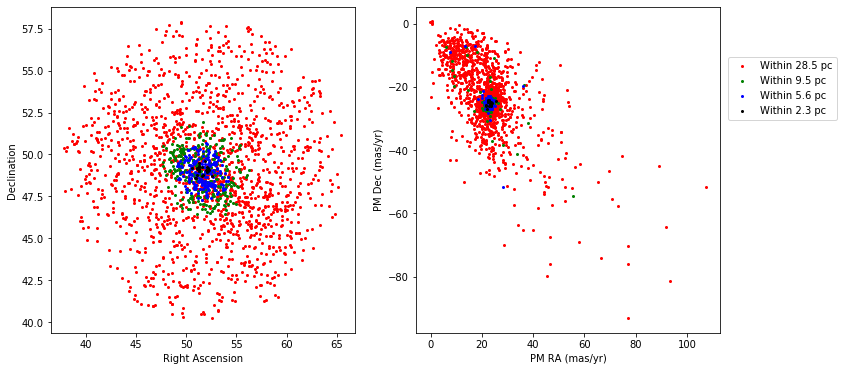

In [14]:
#@title RA, Dec, and PM

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(3,-1,-1):
  pdf = alpha_per.objs.query('DistanceBin == @labs[@i]')
  ax[0].scatter(pdf.RAdeg, pdf.DEdeg, color=bin_colors[i], label=labs[i], s=4)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Right Ascension')
_=ax[0].set_ylabel('Declination')

for i in range(3,-1,-1):
  pdf = alpha_per.objs.query('DistanceBin == @labs[@i]')
  ax[1].scatter(pdf.pmRA, pdf.pmDE, color=bin_colors[i], label=labs[i], s=4)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_xlabel('PM RA (mas/yr)')
_=ax[1].set_ylabel('PM Dec (mas/yr)')


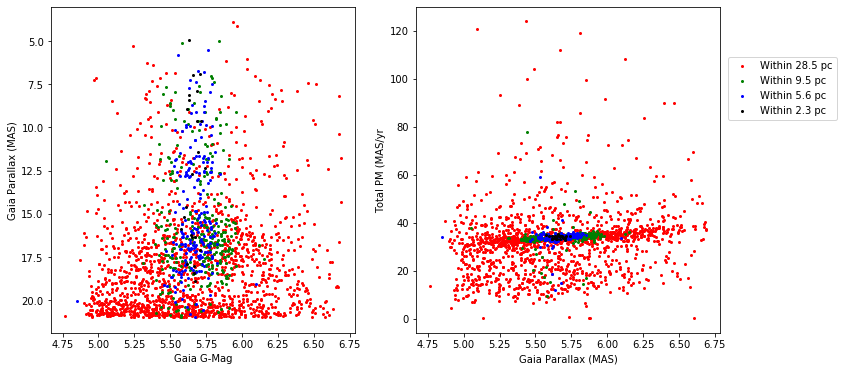

In [15]:
#@title Magnitude and PM v. Parallax

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(3,-1,-1):
  pdf = alpha_per.objs.query('DistanceBin == @labs[@i]')
  ax[0].scatter(pdf.Plx, pdf.Gmag, color=bin_colors[i], label=labs[i], s=4)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Gaia G-Mag')
ax[0].invert_yaxis()
_=ax[0].set_ylabel('Gaia Parallax (MAS)')

for i in range(3,-1,-1):
  pdf = alpha_per.objs.query('DistanceBin == @labs[@i]')
  ax[1].scatter(pdf.Plx,
                np.sqrt(pdf.pmRA**2 + pdf.pmDE**2),
                 color=bin_colors[i], label=labs[i], s=4)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_ylabel('Total PM (MAS/yr')
_=ax[1].set_xlabel('Gaia Parallax (MAS)')

Text(0.5, 1.0, 'Count by Distance Bin')

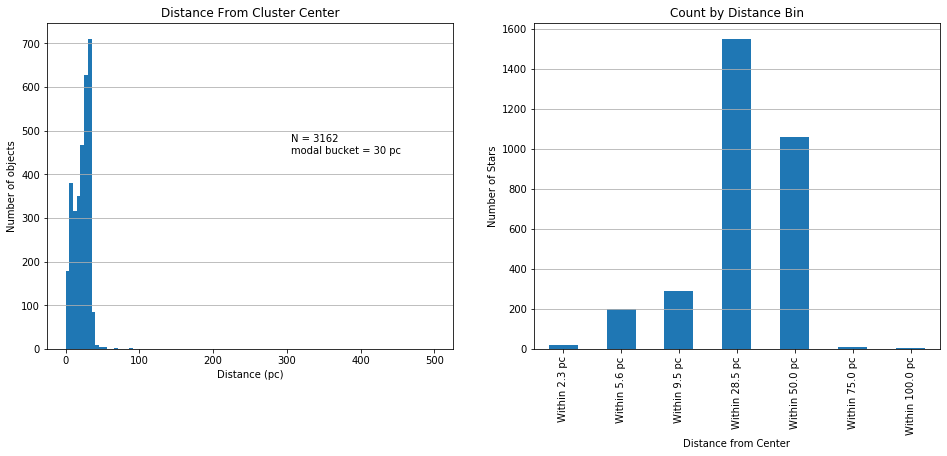

In [17]:
#@title Distance from Center Histograms
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
zz=ax[0].hist(alpha_per.objs.distC, bins=np.linspace(0,500,100, endpoint=True))
ax[0].set_ylabel('Number of objects')
un = u.parsec
ax[0].set_xlabel(f'Distance ({un})')
ax[0].set_title('Distance From Cluster Center')
N = len(alpha_per.objs)
mode = zz[1][zz[0].argmax()]
ax[0].text(0.60, 0.60,f'N = {N}\nmodal bucket = {mode:.0f} pc',transform=ax[0].transAxes)
ax[0].grid(axis='y')
#ax.axvline(alf_per_dist, color='red',label=r'$\alpha Per$')
#ax.legend()

alpha_per.objs.groupby('DistanceBin').size().plot(kind='bar', ax=ax[1])
ax[1].set_ylabel('Number of Stars')
ax[1].set_xlabel('Distance from Center')
ax[1].grid(axis='y')
ax[1].set_title("Count by Distance Bin")

# Query Gaia

In [ ]:
!pip install pyvo

In [21]:
from astropy.pyvo import pyvo

ModuleNotFoundError: No module named 'astropy.pyvo'

In [19]:
alpha_per.findcolumns('gaia')

[('SourceCP', 'Gaia DR2 source_id (SOURCE_ID_CP)'),
 ('Source', 'Gaia DR2 source_id (source_id)'),
 ('Plx', 'Gaia DR2 parallax (parallax)'),
 ('e_Plx', 'Gaia DR2 parallax error (parallax_error)'),
 ('pmRA', 'Gaia DR2 proper motion along RA, pmRA*DE (pmra)'),
 ('e_pmRA', 'Gaia DR2 proper motion along RA error (pmra_error)'),
 ('pmDE', 'Gaia DR2 proper motion along DE (pmdec)'),
 ('e_pmDE', 'Gaia DR2 proper motion along DE error (pmdec_error)'),
 ('RAgdeg', 'Gaia DR2 right ascension (ICRS) at epoch 2015.5 (ra)'),
 ('DEgdeg', 'Gaia DR2 declination (ICRS) at epoch 2015.5 (dec)'),
 ('e_Gmag',
  'Gaia DR2 Standard error of G-band mean magnitude (Vega)(phot_g_mean_mag_error)'),
 ('angDist1', '? Distance to Gaia DR2 source (angDist_1)'),
 ('RUWE', 'Gaia DR2 Re-normalised Unit Weight Error (ruwe)')]

In [20]:
alpha_per.findcolumns('phot_.*_mean_mag')

[('Gmag', 'G-band mean magnitude (Vega) (phot_g_mean_mag)'),
 ('BPmag', '? Integrated BP mean magnitude (Vega) (phot_bp_mean_mag)'),
 ('RPmag', '? Integrated RP mean magnitude (Vega) (phot_rp_mean_mag)'),
 ('e_Gmag',
  'Gaia DR2 Standard error of G-band mean magnitude (Vega)(phot_g_mean_mag_error)'),
 ('e_BPmag',
  '? Standard error of BP mean magnitude (Vega) (phot_bp_mean_mag_error)'),
 ('e_RPmag',
  '? Standard error of RP mean magnitude (Vega) (phot_rp_mean_mag_error)')]

From Lodieu mean distance to $\alpha Per$ is Per $177.68\pm0.84 pc $ so we'll query 170 and 185 PC.

In [ ]:
np.median(alpha_per.rest),alpha_per.rest.mean(), alpha_per.rest.std(), alpha_per.rest.max()

In [ ]:
# center of the observations:
ra = alpha_per.RAdeg.mean(); dec = alpha_per.DEdeg.mean()

#angular distance from center for each obs:
ang_dist = np.sqrt((alpha_per.RAdeg - ra)**2 + (alpha_per.DEdeg-dec)**2)
search_r = ang_dist.max()

#distance constraint (10% on either side of median):
med_dist = np.median(alpha_per.rest)

print(f'Search cone: ra: {ra}, dec: {dec}, search radius: {search_r}')
print(f'Distance constraint: between {med_dist*.9} and {med_dist*1.1}')

In [ ]:
zz=plt.hist(ang_dist,bins=50)

In [ ]:
#@title Tap Query String
tap_query_string = '\n'.join([
'select \tgs.source_id as Source ',
        '\t\t,gs.ra as RAdeg ',
        '\t\t,gs.dec as DEdeg ',
        '\t\t,gs.parallax as Plx ',
        '\t\t,gs.pmra as pmRA ',
        '\t\t,gs.pmdec as pmDE ',
        '\t\t,gs.phot_g_mean_mag as Gmag ',
        '\t\t,gs.phot_bp_mean_mag as BPmag ',
        '\t\t,gs.phot_rp_mean_mag as RPmag ',
        '\t\t,gd.r_est as rest ',
    'from gaiadr2.gaia_source gs ',
    '\tleft join gaiadr2_complements.geometric_distance gd using (source_id) ',
    'where ', 
          '\tCONTAINS(POINT(\'ICRS\', gs.ra, gs.dec), ',
              '\t\tCIRCLE(\'ICRS\', {ra}, {dec}, {rad})) = 1 '.format(ra=ra, dec=dec, rad=search_r),
      '\tand gd.r_est between {r_lo} and {r_hi}'.format(r_lo=med_dist*0.9, r_hi=med_dist*1.1),
      '\tand gs.parallax_over_error > 5.0'
])

print(tap_query_string)

In [ ]:
"""
#1. Import the relevant modules/classes/packages
from pyvo.dal import TAPService

#2. Query the ARI Gaia TAP Service
tap_service_url = "http://gaia.ari.uni-heidelberg.de/tap"
tap_service = TAPService(tap_service_url)
tap_results = tap_service.search(tap_query_string);

print(f'query returned {len(tap_results)} rows')
"""

In [ ]:
alpha_per.set_index('Source', inplace=True)

In [ ]:
import pickle
path = './data/tap_query.pkl'
with open(path, 'rb') as pkl:
    tap_df = pickle.load(pkl)

In [ ]:
tap_df = tap_results.to_table().to_pandas()
tap_df.set_index('source', inplace=True)

In [ ]:
"""
import pickle
path = './data/tap_query.pkl'
with open(path,'wb') as pkl:
  pickle.dump(tap_df, pkl)
"""

In [ ]:
tap_df.head()

### Make Consolidated Data Frame

In [ ]:
#need the colnames in lower case because that's what the tap query returns
alpha_per_lc = alpha_per.rename(columns = dict([(s,s.lower()) for s in alpha_per.columns]))

In [ ]:
alpha_per_lc.head()

In [ ]:
mycols = [s.lower() for s in ['radeg','DEdeg','Plx', 'pmRA', 'pmDE','Gmag','BPmag','RPmag','rest']]

consol_df=tap_df.merge(alpha_per_lc[mycols],how='outer',left_index=True, right_index=True,indicator=True)

In [ ]:
consol_df._merge.value_counts()

In [ ]:
consol_df['which'] = consol_df._merge.apply(lambda s: 'lodieu' if s == 'right_only' else 'tap' if s == 'left_only' else 'both')
for c in mycols:
  consol_df[c]=np.where(np.isnan(consol_df[c+'_x']), consol_df[c+'_y'], consol_df[c+'_x'])

consol_df.drop(columns = [s+'_x' for s in mycols]+[s+'_y' for s in mycols], inplace=True)

In [ ]:
consol_df.which.value_counts()

In [ ]:
consol_df.query('which == \'lodieu\'').head()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for s,c in zip(['tap','both','lodieu',],['red','green','blue']):
  pdf = consol_df.query('which == @s')
  ax[0].scatter(pdf.radeg, pdf.dedeg, color=c, label=s, s=2, alpha=0.3)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Right Ascension')
_=ax[0].set_ylabel('Declination')

for s,c in zip(['tap','both','lodieu'],['red','green','blue']):
  pdf = consol_df.query('which == @s')
  ax[1].scatter(pdf.pmra, pdf.pmde, color=c, label=s, s=2, alpha=0.3)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_xlabel('PM RA (mas/yr)')
_=ax[1].set_ylabel('PM Dec (mas/yr)')


In [ ]:
consol_df.query('which == \'lodeiu\'').head()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for s,c in zip(['tap','both','lodieu',],['red','green','blue']):
  pdf = consol_df.query('which == @s')
  ax.set_yscale('log')
  ax.hist(pdf.rest,bins=np.linspace(0,500,100, endpoint=True), color=c, label=s,  alpha=0.3)
ax.legend()

In [ ]:
consol_df.query('rest >= 165.15045  and rest <=201.85055').which.value_counts()

In [ ]:
#build balanced data frame
members = consol_df.query('which==\'both\'')
n_both = len(members)
non_members = consol_df.query('which==\'tap\'').sample(n=n_both, random_state=1234)
balanced_df = pd.concat([members, non_members])

#shuffle it up
np.random.seed(4321)
balanced_df = balanced_df.loc[np.random.permutation(balanced_df.index)]

#ditch rows with NaNs
balanced_df.dropna(inplace=True)

#binary value for candidacy
balanced_df['candidate'] = np.where(balanced_df.which == 'both', 1, 0)

balanced_df.which.value_counts()

In [ ]:
balanced_df.info()

In [ ]:
np.any(balanced_df.gmag==-9999.0)

In [ ]:
# partition to train, val and test dataframes
test_frac = 0.2; train_frac = 0.65; val_frac = 1.0 - test_frac - train_frac
nrows = len(balanced_df)
test_n = int(test_frac*nrows); train_n=int(train_frac*nrows); val_n=nrows-test_n-train_n

train_df = balanced_df.iloc[:train_n]
val_df = balanced_df.iloc[train_n:train_n+val_n]
test_df = balanced_df.iloc[train_n+val_n:]

len(train_df), len(val_df), len(test_df), nrows

# Classifier Models

In [ ]:
# some needed libraries
from sklearn.model_selection import train_test_split # to partition the dataset into training and test
from sklearn.metrics import accuracy_score, confusion_matrix # for model evaluation
from sklearn.linear_model import LogisticRegression # classifier model to test

In [ ]:
# function to create features from input data set
# returns (n,4) feature matrix and (n,) label vector
def get_features_labels(df):
    features = np.zeros((len(df), 5))
    features[:,0] = np.array(df.pmra)
    features[:,1] = np.array(df.pmde)
    features[:,2] = np.array(df.bpmag - df.gmag)
    features[:,3] = np.array(df.gmag - df.rpmag)
    features[:,4] = np.array(np.sqrt(df.pmra**2+df.pmde**2))
    labels = np.array(df.candidate)
    return features, labels

In [ ]:
#get the features and labels for each of the sets
x_train,  y_train  = get_features_labels(train_df)
x_val,  y_val  = get_features_labels(val_df)
x_test, y_test = get_features_labels(test_df)

## Logit Classifier

In [ ]:
logit_model = LogisticRegression()
logit_model.fit(x_train,y_train)

In [ ]:
# calculate prediction accuracy on the dev set
pred_ovr_train = logit_model.predict(x_train)
acc_ovr_train = accuracy_score(y_train, pred_ovr_train)

#calculate prediction accuracy on the validation set
pred_ovr_val = logit_model.predict(x_val)
acc_ovr_val = accuracy_score(y_val, pred_ovr_val)

print('OVR Training Set Accuracy: ', acc_ovr_train)
print('OVR Validation Set Accuracy: ', acc_ovr_val)

In [ ]:
confusion_matrix(y_val, pred_ovr_val)

In [ ]:
logit_model.classes_

## K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neighbors = KNeighborsClassifier()
neighbors.fit(x_train, y_train)

In [ ]:
# calculate prediction accuracy on the dev set
pred_knn_train = neighbors.predict(x_train)
acc_knn_train = accuracy_score(y_train, pred_knn_train)

#calculate prediction accuracy on the validation set
pred_knn_val = neighbors.predict(x_val)
acc_knn_val = accuracy_score(y_val, pred_knn_val)

print('KNN Training Set Accuracy: ', acc_knn_train)
print('KNN Validation Set Accuracy: ', acc_knn_val)

In [ ]:
confusion_matrix(y_val, pred_knn_val)

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

In [ ]:
# calculate prediction accuracy on the dev set
pred_dtc_train = dtc.predict(x_train)
acc_dtc_train = accuracy_score(y_train, pred_dtc_train)

#calculate prediction accuracy on the validation set
pred_dtc_val = dtc.predict(x_val)
acc_dtc_val = accuracy_score(y_val, pred_dtc_val)

print('DTC Training Set Accuracy: ', acc_dtc_train)
print('DTC Validation Set Accuracy: ', acc_dtc_val)

## Ensemble

In [ ]:
def ensemble(modlist, X):
  """
  only works for binary classifiers
  """
  thresh = np.ceil(len(modlist)/2.0)
  yhat = np.array([m.predict(X) for m in modlist])
  yhat_ens = np.where(yhat.sum(axis=0)>=thresh,1,0)
  return yhat_ens


In [ ]:
modlist = [logit_model, neighbors, dtc]

In [ ]:
# calculate prediction accuracy on the dev set
pred_ens_train = ensemble(modlist, x_train)
acc_ens_train = accuracy_score(y_train, pred_ens_train)

#calculate prediction accuracy on the validation set
pred_ens_val = ensemble(modlist, x_val)
acc_ens_val = accuracy_score(y_val, pred_ens_val)

print('ENS Training Set Accuracy: ', acc_ens_train)
print('ENS Validation Set Accuracy: ', acc_ens_val)

In [ ]:
confusion_matrix(y_val, pred_ens_val)

In [ ]:
confusion = pd.DataFrame([confusion_matrix(y_val, pred_ovr_val).flatten(),
                          confusion_matrix(y_val, pred_knn_val).flatten(),
                          confusion_matrix(y_val, pred_dtc_val).flatten(),
                          confusion_matrix(y_val, pred_ens_val).flatten()],
                    index=['LogitRegr','KNN', 'DTC', 'Ens'],
                    columns = ['Tpos','Fneg','Fpos','Tneg'])

In [ ]:
confusion

In [ ]:
acc_ens_train.shape, pred_dtc_train.shape

In [ ]:
train_acc = (acc_ovr_train, acc_knn_train, acc_dtc_train, acc_ens_train)
val_acc = (acc_ovr_val, acc_knn_val, acc_dtc_val, acc_ens_val)

ind = np.arange(len(train_acc))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, train_acc, width, 
                label='Training')
rects2 = ax.bar(ind + width/2, val_acc, width, 
                label='Validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Method and Partition')
ax.set_xticks(ind)
ax.set_xticklabels(('LogitRegr', 'KNN', 'DecisionTree', 'Ensemble'))
ax.legend()

# Old Stuff

In [ ]:
def get_stars(ra, dec, rad=2.0*u.degree):
    query_text = "SELECT  \
                random_index, ra, dec, parallax, pmra, pmdec, radial_velocity,\
                phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, teff_val, radius_val, lum_val \
                FROM gaiadr2.gaia_source \
            WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec), \
                    CIRCLE('ICRS',{ra},{dec},{rad}))=1 \
                    and parallax_over_error > 5 ".format(ra=ra.value, dec=dec.value, rad=rad.value)
                    #--AND abs(pmra_error/pmra)<0.10 \
                    #--AND abs(pmdec_error/pmdec)<0.10 \
                    #--AND pmra IS NOT NULL AND abs(pmra)>0 \
                    #--AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                    #--and parallax IS NOT NULL and parallax > 0".format(ra=ra.value, dec=dec.value, rad=rad.value)
    
    job = Gaia.launch_job_async(query_text)
    gaia_data = job.get_results()

    result_dict = {}
    result_dict['dist'] = coord.Distance(parallax=u.Quantity(gaia_data['parallax']),allow_negative=True)
    result_dict['coord']=  coord.SkyCoord(ra=gaia_data['ra'],
                   dec=gaia_data['dec'],
                   distance=result_dict['dist'],
                   pm_ra_cosdec=gaia_data['pmra'],
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])
    result_dict['M_G'] = gaia_data['phot_g_mean_mag'] - result_dict['dist'].distmod
    result_dict['BP_RP'] = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']
    
    result_dict['data'] = gaia_data.to_pandas()

    return result_dict

In [ ]:
#don't execute this query
#clust = get_stars(alf_per.ra, alf_per.dec)

In [ ]:
#nor this
#len(clust['data'])

In [ ]:
# the file colnames.txt extracted from Readme.txt that came with the archive.  Provides column names for the alpha_per and pleiades data sets
colnames_txt_path = './gdrive/My Drive/cas-tau/Cass-Tau/data/J_A+A_628_A66/colnames.txt'
with open(colnames_txt_path,'r') as f:
    colnames_txt = f.readlines()
colnames = [s.strip() for s in colnames_txt]
colnames = [s for s in colnames if s] #ditch the blanks

In [ ]:
# read up the two data files
path = './gdrive/My Drive/cas-tau/Cass-Tau/data/J_A+A_628_A66/alphaper.dat'
alpha_per = pd.read_csv(path, delim_whitespace=True, error_bad_lines=False, warn_bad_lines=True,
                        header=None,usecols=range(len(colnames)), names=colnames)
path = './gdrive/My Drive/cas-tau/Cass-Tau/data/J_A+A_628_A66/pleiades.dat'
pleiades = pd.read_csv(path, delim_whitespace=True, error_bad_lines=False, warn_bad_lines=True,
                        header=None,usecols=range(len(colnames)), names=colnames)

In [ ]:
alpha_per.info()

In [ ]:
(alpha_per.RVCP==-9999.0).sum()/len(alpha_per)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
zz=ax.hist(alpha_per.rest,bins=np.linspace(0,500,50, endpoint=True))
ax.set_ylabel('Number of objects')
un = u.parsec
ax.set_xlabel(f'Distance ({un})')
ax.set_title('Distance Histogram')
N = len(alpha_per)
mode = zz[1][zz[0].argmax()]
ax.text(0.60, 0.60,f'N = {N}\nmodal bucket = {mode:.0f} pc',transform=ax.transAxes)
ax.grid(axis='y')
ax.axvline(alf_per_dist, color='red',label=r'$\alpha Per$')
ax.legend()

In [ ]:
clust['data'].head()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

zz=ax[0].hist(np.array(clust['dist']),bins=50, alpha=0.5)
ax[0].set_ylabel('Number of objects')
un = clust['dist'][0].unit
ax[0].set_xlabel(f'Distance ({un})')
ax[0].set_title('Distance Histogram')
N = len(clust['data'])
ax[0].text(6000,4100,f'N = {N}')
ax[0].grid(axis='y')
ax[0].axvline(155, color='red',label=r'$\alpha Per$')
ax[0].legend()


pcm=ax[1].scatter(clust['data'].pmra, clust['data'].pmdec, s=1., alpha=0.5,
           c = clust['dist'],
           cmap='plasma')

un = clust['dist'][0].unit

cbar = fig.colorbar(pcm)
cbar.set_label(f'Distance ({un})', rotation=270)
ax[1].set_xlim(-75,75)
ax[1].set_ylim(-75,75)
ax[1].set_title('Proper Motions')
ax[1].set_ylabel('Declination')
ax[1].set_xlabel('Right Ascension')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

pcm = ax.scatter(clust['BP_RP'], clust['M_G'],
        marker='.', alpha=0.5,c = 'blue', s=2) #,
           #cmap='plasma_r', norm=colors.PowerNorm(gamma=0.5,vmin=gaia_data_r['teff_val'].min(), vmax=gaia_data_r['teff_val'].max()))

#ax.set_xlim(0, 3)
#ax.set_ylim(11, 1)
ax.invert_yaxis()

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
ax.set_title('HR Diagram')
#cbar = fig.colorbar(pcm)
#cbar.ax.set_ylabel( 'Effective Temperature (K)', rotation=270)